In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import networkx as nx
import os
import sys
import json
import random
import re
from math import ceil, floor, log, log2, log10, sqrt, exp, factorial, gcd, lcm, pi, e, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2
from collections import Counter, defaultdict, OrderedDict, namedtuple, deque
from functools import partial, partialmethod, reduce, wraps, cache, lru_cache, cached_property, singledispatch, singledispatchmethod
from itertools import count, cycle, product as cartesian_product, permutations, combinations, combinations_with_replacement, accumulate, starmap
from tqdm import tqdm # from tqdm.notebook import tqdm
from uuid import uuid4
from datetime import datetime, timedelta
from time import time, sleep
from toolz import memoize, curry, diff, unique, valmap, valfilter, itemmap, itemfilter, keymap, keyfilter, merge_sorted, interleave, isdistinct, diff, peek, peekn, countby, juxt, excepts, merge, merge_with, assoc, dissoc
from more_itertools import unzip, chunked, chunked_even, minmax, filter_except, numeric_range, make_decorator,replace, locate,countable,unique_everseen, always_iterable,unique_justseen,map_except,count_cycle, mark_ends, sample, distribute, bucket, peekable, seekable,spy,transpose, sieve,polynomial_from_roots,flatten, intersperse, partition, powerset, collapse, split_at, flatten,split_before, split_after, split_when, take

sys.path.append(os.path.relpath("../../src/"))
from network_v3 import * # my classes and functions

In [2]:
SEED = 42

In [3]:
def uniform_sample(n ,long_grid = 100, lat_grid = 100, pop_size=200 , long_spread = 200, lat_spread = 200,seed = SEED):
    npr.seed(seed)
    x = npr.uniform([0,0,pop_size/(long_spread*lat_spread),pop_size/(long_spread*lat_spread)],[long_grid,lat_grid,long_spread,lat_spread],size=(n,4))
    y = npr.randint(0,pop_size ,size=(n,1)).transpose()
    # returns xy-coordinates, population, mean, spread, size
    return np.concatenate((x,y.transpose()),axis=1)

def normal_sample(n,mean = [0,0] , std = [1,1], seed = SEED):
    npr.seed(seed)
    covs = [[std[0],0],[0,std[1]]]
    x = npr.multivariate_normal(mean,covs,size=n)
    #plt.plot(x[:,0],x[:,1],'.')
    return x

In [4]:
# seed= SEED
# rng = npr.default_rng(seed = seed)
# population_centers = uniform_sample(10, long_grid = 80, lat_grid = 80, pop_size=250 , long_spread = 150, lat_spread = 150,seed = seed)
# population = [normal_sample(int(i[4]),(i[0],i[1]),(i[2],i[3]),seed=seed) for i in population_centers]
# population_midpoints = [(i[0],i[1]) for i in population_centers]
# population_midpoint = reduce(lambda x,y: (x[0]+y[0],x[1]+y[1]),population_midpoints)
# population_midpoint = (population_midpoint[0]/len(population_midpoints),population_midpoint[1]/len(population_midpoints))
# population_spread = max([max([np.linalg.norm(i-population_midpoint) for i in j]) for j in population])
# population.append(normal_sample(1000,population_midpoint,(population_spread*2,population_spread*2),seed=seed))
# pop = np.concatenate(population,axis=0)

# plt.plot(pop[:,0],pop[:,1],marker='.',linestyle='None',color='g')

In [5]:
def city_sample(n ,long_grid = 80, lat_grid = 80, pop_size=250 , long_spread = 150, lat_spread = 150,seed = SEED,rd = 10):
    population_centers = uniform_sample(10, long_grid = 80, lat_grid = 80, pop_size=250 , long_spread = 150, lat_spread = 150,seed = seed)
    population = [normal_sample(int(i[4]),(i[0],i[1]),(i[2],i[3]),seed=seed) for i in population_centers]
    population_midpoints = [(i[0],i[1]) for i in population_centers]
    population_midpoint = reduce(lambda x,y: (x[0]+y[0],x[1]+y[1]),population_midpoints)
    population_midpoint = (population_midpoint[0]/len(population_midpoints),population_midpoint[1]/len(population_midpoints))
    population_spread = max([max([np.linalg.norm(i-population_midpoint) for i in j]) for j in population])
    population.append(normal_sample(1000,population_midpoint,(population_spread*2,population_spread*2),seed=seed))
    pop = np.concatenate(population,axis=0)
    pop_rd = np.array(list(map(lambda x: [round(x[0],rd),round(x[1],rd)],pop)))
    plt.plot(pop_rd[:,0], pop_rd[:,1],marker='.',linestyle='None',color='g')
    return pop_rd , population_centers, population_midpoint

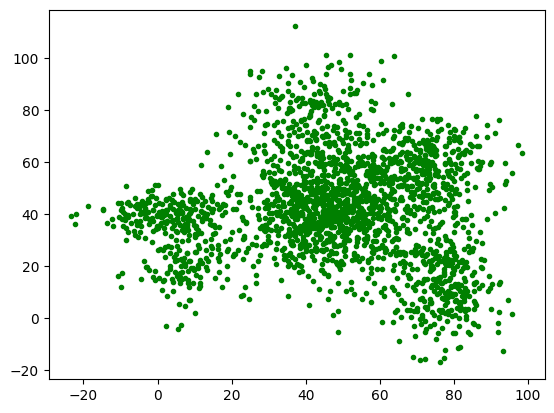

In [6]:
city_sample(10,rd=2,seed = 9);

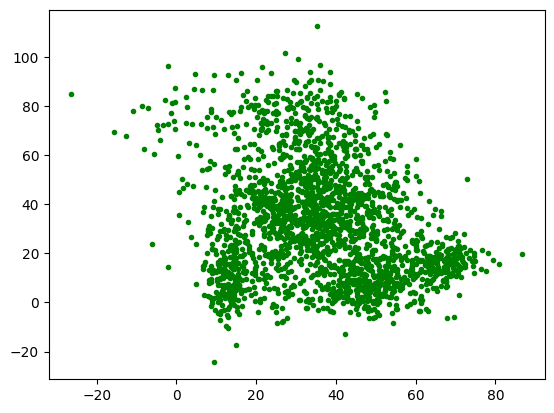

In [7]:
pop , population_centers, population_midpoint = city_sample(10,rd=2,seed = SEED)

population_midpoint_node = Node.make(*population_midpoint)
nodes = [Node.make(*i, weight = lambda x : x.dist_to(population_midpoint_node)) for i in pop]

In [8]:
def node_neighbors(node,nodes,radius, distance_function = lambda x,y : x.dist_to(y,metric = 'manhattan')):
    neighbors = []
    for i in nodes:
        if distance_function(node,i) < radius:
            neighbors.append(i)
    neighbors.remove(node)
    neighbors.sort(key = lambda x : distance_function(node,x))
    return neighbors

def neighborhood(node,nodes,min=3 ,distance_function = lambda x,y : x.dist_to(y,metric = 'manhattan')):
    r = 1
    x = node_neighbors(node,nodes,r,distance_function=distance_function)
    while len(x) < min:
        r+=1
        x = node_neighbors(node,nodes,r)
        if r > 100:
            break
    return x

neighbor_dict = {i:neighborhood(i,nodes,3*(max(i.weight//10,1))) for i in nodes}

In [9]:
def road_picker(node, neighborhood):
    npr.seed(int(node.weight*1000))
    edges = [Edge.make(node,i,weight = lambda x: Node.dist(x.node1, x.node2,metric = 'manhattan')) for i in neighborhood]
    picks = min(max(npr.poisson(2),1),len(neighborhood)-1)
    res = [edges[0],edges[1]] + list(npr.choice(edges[2:],size=picks))
    return res

In [10]:
edges = []
for i in nodes:
    edges.extend(road_picker(i,neighbor_dict[i]))

In [11]:
city = Network(nodes,edges)

In [12]:
len(city.nodes), len(city.edges)

(2184, 6140)

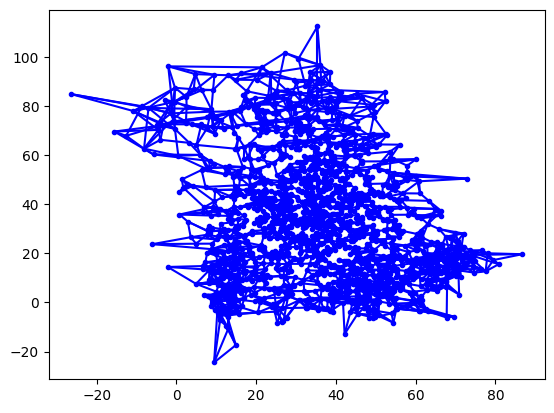

In [13]:
def plot_network(network, color = 'b', marker = '.', linestyle = 'None', alpha = 1):
    x = [node.x for node in network.nodes]
    y = [node.y for node in network.nodes]
    plt.plot(x,y,marker = marker, linestyle = linestyle, color = color, alpha = alpha)
    for edge in network.edges:
        plt.plot([edge.node1.x,edge.node2.x],[edge.node1.y,edge.node2.y],color = color, alpha = alpha)
    return
plot_network(city)

In [14]:
### Project ideas:
### Randomly generate population density (eg random points in a square, normal distribution around a point, random means and variances for each point, etc.)
### can we position n distribution centers in a way that minimizes the total distance traveled by the population?
### given distribution centers and budget for m more, can we find the best locations for m more centers?
### analyze the impact of closing centers
### Given a cost of movement and expected profit, can we find if it's worth it to move a center?
### Do this with real data (eg map)
### Cycle analysis (how to choose  best route for a delivery person)
### Traffic flow? (would it be better having a center in the middle of a city or on the outskirts? What if they open in a jagged pattern?)
### Traffic jams? (how to minimize the impact of traffic jams on the delivery person?)
### Can we find the best route for a delivery person that minimizes the total distance traveled and the total time spent in traffic jams?

# Changes - Remove multiedges

In [103]:
from scipy.sparse import csr_matrix
import scipy.sparse.csgraph as csgraph
from scipy.sparse.csgraph import floyd_warshall

In [48]:
for i in city.nodes:
    i.index = city.nodes.index(i)

In [136]:
city_matrix = np.zeros((len(city.nodes),len(city.nodes)))
for i in city.nodes:
    for j in city.adjacent_edges(i):
        k = j.node1 if j.node1 != i else j.node2
        city_matrix[i.index,k.index] = j.weight
        city_matrix[k.index,i.index] = j.weight
cs = csr_matrix(city_matrix)

In [132]:
fw_matrix, predecessors = floyd_warshall(cs, directed=False, return_predecessors=True)

In [133]:
avg_dist = sum(fw_matrix)/(fw_matrix.shape[0] - 1)
avg_dist.min()

36.77920293174526

In [134]:
y = np.where(avg_dist == min(avg_dist))
city.nodes[y[0][0]]
y[0][0]

2131

In [ ]:
distance_dict = {}
for i,j in cartesian_product(city.nodes,city.nodes):
    if i != j:
        for k in city.nodes:
            if k != i and k != j:
                